# Table of Contents
## 0. [Imports, data loading and checking](#DL)
## 1. [Features properties](#FP)
## 2. [Features enginering](#FE)
## 3. [Model hipothesis and discussion](#MH)
## 4. [Model building](#MB)
## 5. [Model selection](#MS)
## 6. [Conclussions](#C)
## 7. [Submission](#S)

In [1]:
import sys  
sys.path.insert(0, '../src/visualization/') # add path containing visualize
sys.path.insert(0, '../src/data/') # add path containing visualize

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import visualize as vsl  # own visualize.py file containing every visualization scripts

import titanic_submission
import re

from scipy.stats import kstest, kurtosis, shapiro, skew
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [9,6]

# 0. Data loading and checking <a class="anchor" id="DL"></a>shapiro

In [3]:
train_data = pd.read_csv('../data/raw/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can see that Age, Embarked and Cabin contain null values, so, we will keep it in mind (in order to fill them) if we consider that some of these features is relevant after the properties overview.

# 1. Features properties <a class="anchor" id="FP"></a>

In this section we are going to study the features properties in order to two main aspects:

1. Marginal Distribution to know how a feature acts marginally 

2. Joint distribution with Survived to know which features are significantly related with the survivors

The methodology is basicly take an overview with a pie chart (in the case of cathegorical features) or an histogram (in the case of numerical values), then we will plot the joint distribution with a stacked bars diagram (in the case of cathegorical features) or an histogram hued by survivor (in the case of numerical features).

## 1.1 PassengerId

This feature seems to be a unique identifier for every passenger, but we do not need it because it matches with our dataframe indexes. It will be removed.

In [5]:
train_data.drop('PassengerId', axis=1, inplace=True)

## 1.2 Pclass

### MARGINAL DISTRIBUTION

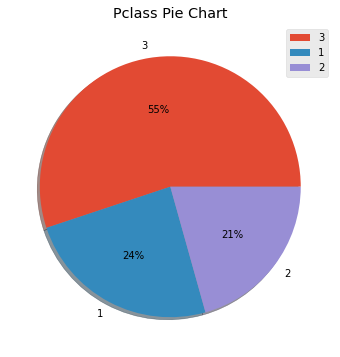

In [6]:
vsl.build_pie_chart(train_data['Pclass'])

### JOINT DISTRIBUTION WITH SURVIVED

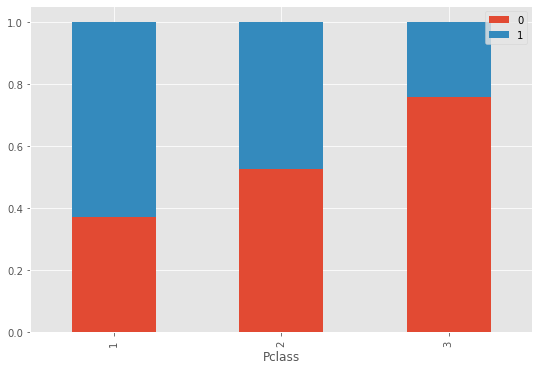

In [7]:
vsl.build_stacked_bars_chart(train_data['Pclass'], train_data['Survived'])

From the above graphic we can see a relation between Survived and Pclass, as we can see, when Pclass decreases survivors proportion increases, so, it could be a feature in the model.

## 1.3 Sex

### MARGINAL DISTRIBUTION

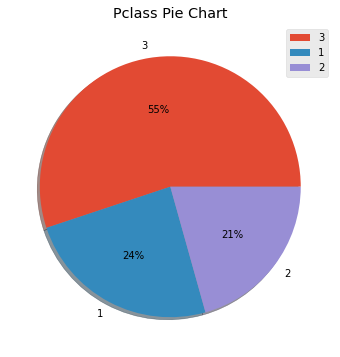

In [8]:
vsl.build_pie_chart(train_data['Pclass'])

### JOINT DISTRIBUTION WITH SURVIVED

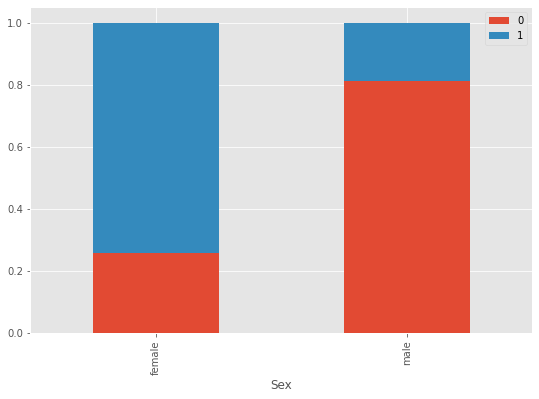

In [9]:
vsl.build_stacked_bars_chart(train_data['Sex'], train_data['Survived'])

We can see that females represent aprroximately the thitd part of the passage, but, they have a significant higher probability to survive than males, so, it could be a feature in the model due to the strong relation.

## 1.4 Age

### MARGINAL DISTRIBUTION

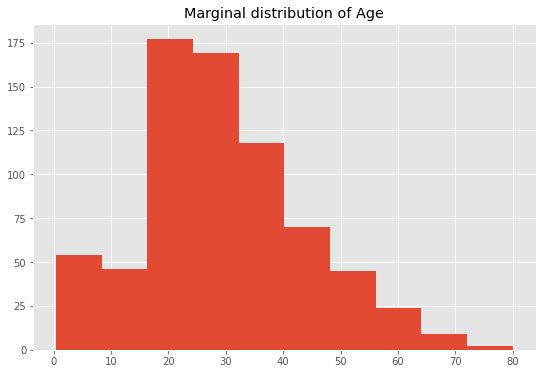

In [10]:
plt.hist(train_data['Age'])
plt.title('Marginal distribution of Age')
plt.show()

From the above histogram we can conclude that a great majority of the passage is between 18 and 30 years approximately. It seems a distribution skewed to the right and it is not any well-known distribution. Specially, The normality assumption it is not justified as we can see in the Kolmogorov-Smirnov pvalue.

In [11]:
kstest(train_data['Age'].dropna(), 'norm')

KstestResult(statistic=0.9650366565902186, pvalue=0.0)

In spite of non normality, we can assume that the distribution is approximately symmetric as we can see in kurtosis and skew coefficients.

In [12]:
print('kurtosis:', kurtosis(train_data['Age'].dropna()), 'skew:', skew(train_data['Age'].dropna()))

kurtosis: 0.16863657224286044 skew: 0.3882898514698657


### JOINT DISTRIBUTION WITH SURVIVED

<AxesSubplot:xlabel='Age', ylabel='Count'>

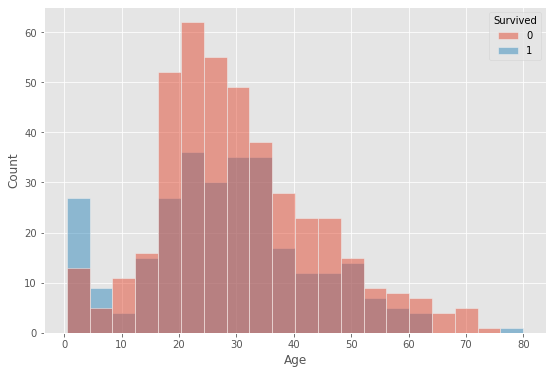

In [13]:
sns.histplot(data=train_data, x='Age', hue='Survived')

We can notice than childs have the highest chance to survive, and in the center of the distribution (young and middle-age persons) have approximately the same probability to survive or not. For the oldest people we can see that, in overall, nobody survived. 

That feature seems useful to predict survivors,so, we will include it in the model, but first, we have to implement a method to fill the null values.

## 1.5 SibSp

### MARGINAL DISTRIBUTION

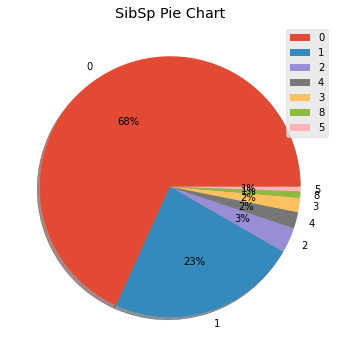

In [14]:
vsl.build_pie_chart(train_data['SibSp'])

### JOINT DISTRIBUTION WITH SURVIVED

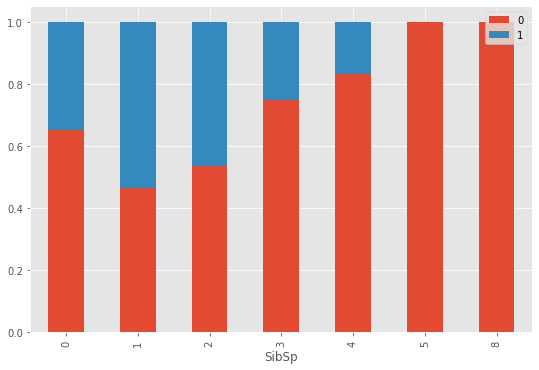

In [15]:
vsl.build_stacked_bars_chart(train_data['SibSp'], train_data['Survived'])

We can see that the probability of survive decreases when SibSp increases (in overall), this feature could be included in the model.

## 1.6 Parch

### MARGINAL DISTRIBUTION

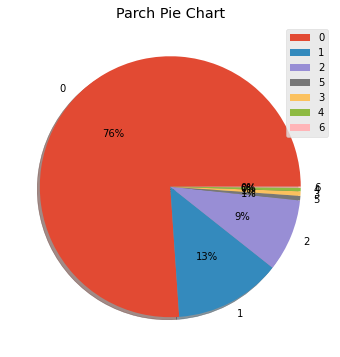

In [16]:
vsl.build_pie_chart(train_data['Parch'])

### JOINT DISTRIBUTION WITH SURVIVED

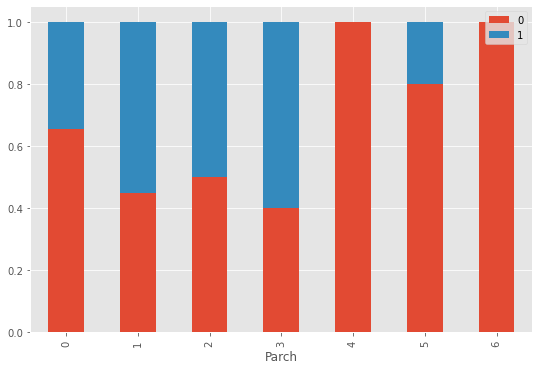

In [17]:
vsl.build_stacked_bars_chart(train_data['Parch'], train_data['Survived'])

From the joint distribution we can see a (slight) relation between the Parch and Survived, where Parch increases the probability of survive decreases.

*Comment*: In overall, that feature has the same relation with survived as SibSp, so, it could be a good idea merge both features in a unique feature to prevent correlation between features in the future model.

## 1.7 Fare

### MARGINAL DISTRIBUTION

<AxesSubplot:xlabel='Fare', ylabel='Count'>

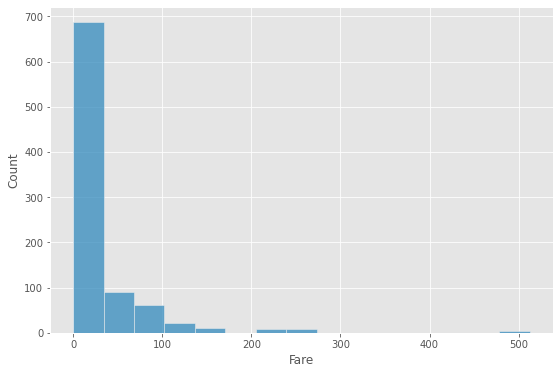

In [18]:
sns.histplot(data=train_data, x='Fare', bins=15)

### JOINT DISTRIBUTION WITH SURVIVED

<AxesSubplot:xlabel='Fare', ylabel='Count'>

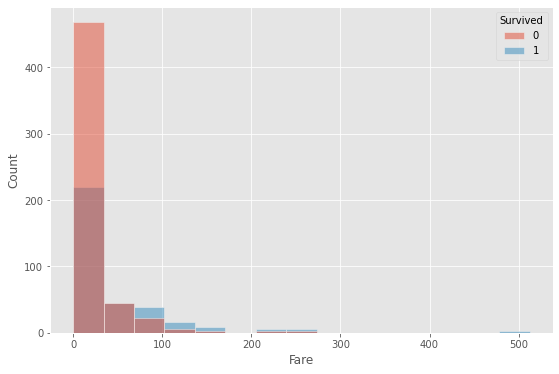

In [19]:
sns.histplot(data=train_data, x='Fare', hue='Survived', bins=15)

We can see that the probability of survive increases when Fare increases, so, it could be a feature in the model, but, probably, its correlated with Pclass, we have to take care if we include both features to prevent high correlations between model features.

## 1.8 Embarked

### MARGINAL DISTRIBUTION

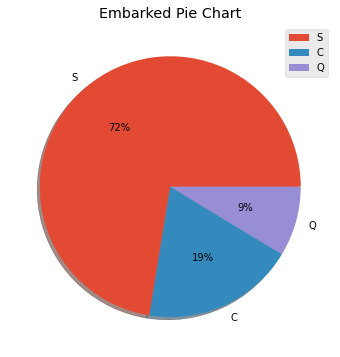

In [20]:
vsl.build_pie_chart(train_data['Embarked'])

### JOINT DISTRIBUTION WITH SURVIVED

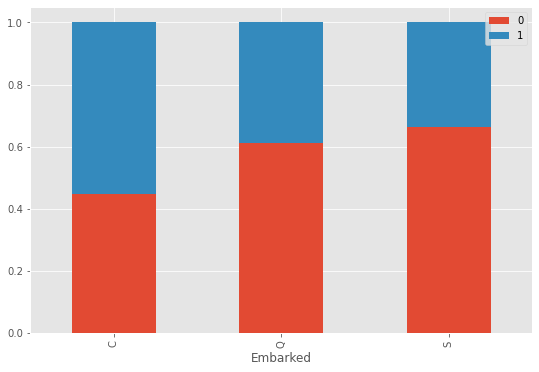

In [21]:
vsl.build_stacked_bars_chart(train_data['Embarked'], train_data['Survived'])

We can see a slight relation between the place where passenger embarked and the probability of survive, but it does not seem significant. We will test different models including or not this feature and we will se if it is relevant or not.

In addition, it has null values as we can see below.

In [22]:
train_data['Embarked'].isnull().sum()

2

Due to the small number of null values we will replace it with the mode.

In [23]:
mode_embarked = train_data['Embarked'].mode()[0]

In [24]:
train_data.loc[train_data['Embarked'].isnull(), 'Embarked'] = mode_embarked
train_data['Embarked'].isnull().sum()  # check if the null values are filled

0

## 1.9 Name

In [25]:
train_data.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In a simplistic approach, names do not seem a reason to survive a disaster, but, if we remind that we need to fill Age null values, definetly, the salutations before the surname can be very useful to locate persons in an age band. We will develop these ideas later.

## 1.11 Ticket and Cabin

That features seem to need a complex feature enginering and modifications, so, we will discuss them later if it is neccessary more complexity to the model.

# 2. Features enginering <a class="anchor" id="FE"></a>

## 2.1 Name. A way to fill Age null values.

In this section, as mentioned previously, we are going to extract passengers salutations with the goal to extract their titles, in addition, it could be a good stratification feature in order to infer an age band for passengers which would allow us to fill Age null values.

Let's take a look of the names format in the dataset.

In [26]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The format seems to be 'name, salutation. surname' so, the appropiate tool to get the salutations will be  a regex rule runned over every Name to keep the string inmediately before the points.

In [27]:
train_data['Title'] = train_data.Name.str.extract('([A-Za-z]+)\.', expand=False) 
train_data['Title'].value_counts(normalize=True)  # overview of saludations

Mr          0.580247
Miss        0.204265
Mrs         0.140292
Master      0.044893
Dr          0.007856
Rev         0.006734
Major       0.002245
Col         0.002245
Mlle        0.002245
Mme         0.001122
Jonkheer    0.001122
Sir         0.001122
Countess    0.001122
Don         0.001122
Capt        0.001122
Ms          0.001122
Lady        0.001122
Name: Title, dtype: float64

We can see that there common salutations such as Mr o Miss, but, we have find multiple salutations which are rare such as Countess or Jonkheer. Seems reasonable to make groups in order to the most common titles and mke and additional group containin rare titles:

1. Mr and Mrs: man and women who are married
2. Miss: women not married
2. Master: an special title for minors. 
3. Rare: those which are not included above

In [28]:
train_data['Title'] = train_data['Title'].apply(lambda x: 
                          1 if x in ['Mr', 'Mrs'] else 
                          (2 if x == 'Miss' else 
                           (3 if x == 'Master' else 4)))

group_means = []

for age_group in train_data['Title'].unique().tolist():
    
    group_means.append(train_data[train_data['Title'].isin([age_group])]['Age'].mean())
    
means_dict = dict(zip(train_data['Title'].unique().tolist(), group_means)) # dict to use with replace

as we can see our stratification seems reasonable, every group has a different age mean.

In [29]:
pd.DataFrame.from_dict(means_dict, orient='index', columns=['mean']).transpose()

,1,2,3,4
mean,33.121542,21.773973,4.574167,42.384615


Finally we can fill the values.

In [30]:
ages_to_fill = train_data[train_data['Age'].isnull()]['Title'].replace(means_dict)
ages_to_fill = ages_to_fill.apply(int) # transform age into int type
train_data.loc[ages_to_fill.index, 'Age'] = ages_to_fill

train_data['Age'].isnull().sum()  # we can check that there is no null values now

0

Before leave this section it could a good idea check the joint distribution of title and Survived, as we said above, Age is related with Survived, so, it is reasonable that our new feature, Title, has inherited that relation, because salutations are based in the age, experience and knowledge.

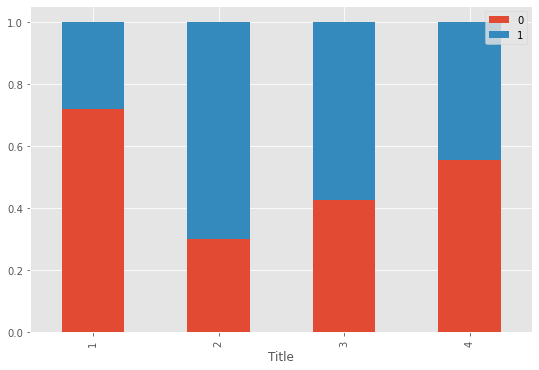

In [31]:
vsl.build_stacked_bars_chart(train_data['Title'], train_data['Survived'])

As expected, the relation is inherited, and probably, it could be a good feature rather than simply Age, we will see in the model selection.

## 2.2 Family features

As we concluded above, SibSp and Parch can duplicate information about a passenger family status in the model, because they showed a similar relation with Survived. It could be a good idea to summarize both features in only one boolean feature that we will call Alone, which values are 1 if the passengers travles alone and 0 if the passenger travels with some family member/s.

In [32]:
train_data['Alone'] = (train_data['SibSp'] + train_data['Parch'] + 1).apply(lambda x: 0 if x!=1 else 1)

As always, now we check the relations with Survived

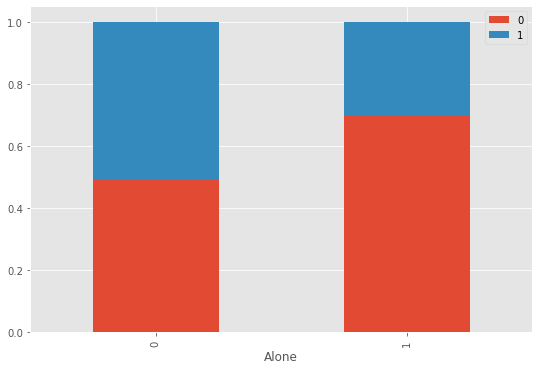

In [33]:
vsl.build_stacked_bars_chart(train_data['Alone'], train_data['Survived'])

And we can see a slight relation between both variables, we will study the feature in the model selection.

## 2.3 Age Features

As an intuition, I propose to create a boolean feature about the elder persons. It reasonable to think that persons who are very old, are more delicated than young persons, so, we will define the threshold to consider someone old in 65 years old, and we will check the relation with Survived.

In [34]:
train_data['Old'] = train_data['Age'].apply(lambda x: 1 if x>65 else 0)

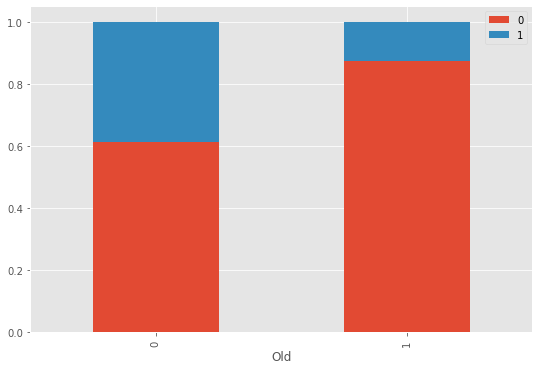

In [35]:
vsl.build_stacked_bars_chart(train_data['Old'], train_data['Survived'])

It seems a strong relation, if some passenger is more than 65, its probability to survive is very low, in the other hand, persons who are not old have approximately the same probability of survive or not, and we could not reject the possibility that the hipothesis is true. We will check it in the model selection.

# 3. Model hipothesis and discussion <a class="anchor" id="MH"></a>

Now we are going to analyse the features and the target variable in order to propose a set of models which can predict which passengers will survive.

* Target feature (to predict): boolean
* Avaible features: boolean, cathegorical, numerical.

In addition, it is highly posible that some variables cumulate information from others, for example, seems reasonable that the highest fares are concentrated in the first Pclass, as we can see below:

<AxesSubplot:xlabel='Fare', ylabel='Count'>

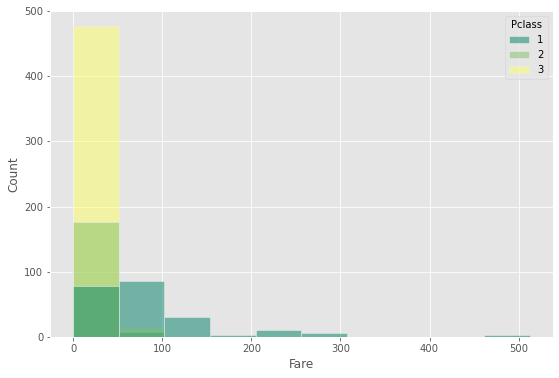

In [36]:
sns.histplot(data=train_data, x='Fare', hue='Pclass', bins=10, palette='summer')

It seems clear that we have to solve a classification problem, so, the classical techniques used in this kind of problems are: Logistic Regression, Decission Trees and his variant Random Forest, Support Vector Classifier, linear classifiers (SVG), Naive Bayes Classifiers...

At the beginning, we will try to fit the most simple and classical models such as Logistic Regression and Decission Trees. If it do not work as expected, we will add more complexity.

# 4. Model building <a class="anchor" id="MB"></a>

From the features analysis we can conclude that strong hipothesis:

1. Females have more chance to survive than males.
2. Minors have more chance to survive than non Minors.
3. Alone passengers have less chance to survive than those passenger who travel with their family.
4. The oldest passengers have less chance to survive than young passengers.
5. The probability of survive increases when pclass decreases.

## 4.1 Basic features of the model

Based on the basic features (proven strong relation) we define the basic features as follows:

1. Isfemale: 1 if the passenger is a female and 0 if not.
2. Isminor: 1 if the passenger is minor and 0 if not.
3. Isalone: 1 if the passenger travels alone and 0 if not.
4. Isold: 1 if the passenger is "very old" and 0 if not
5. A set of dummies which describes pclass: 
    
    Ck :1 if passenger travels in k class and 0 if not for with k = 1, 2 (3 is represented by absence of 1 or 2)

## 4.2 Features creation from the dataset

In [55]:
Isfemale = pd.get_dummies(train_data['Sex'])['female']
Isminor = pd.get_dummies(train_data['Title'])[3]
Isalone = train_data['Alone'].copy()
Isold = train_data['Old'].copy()
C1 = pd.get_dummies(train_data['Pclass'])[1]
C2 = pd.get_dummies(train_data['Pclass'])[2]

basic_model_data = pd.concat([Isfemale, Isminor, Isalone, Isold, C1, C2], axis=1, ignore_index=True)
basic_features = ['Isfemale', 'Isminor', 'Isalone', 'Isold', 'C1', 'C2']
basic_model_data.columns = basic_features

target_feature = train_data['Survived'].copy()

## 4.3 Basic models definition

Now we split model data in train and test samples, and fit, as we said, a Logistic Regression model and a Random Forest model.

In [56]:
#test_features = ['Isfemale', 'Isalone']
# basic_model_data = basic_model_data[test_features]

In [57]:
train_basic_model, test_basic_model,\
train_target_feature, test_target_feature = train_test_split(basic_model_data, target_feature,
                                                         test_size=0.3)

average score: 0.788976279650437


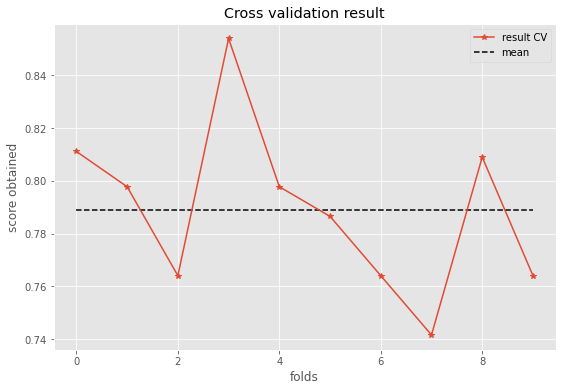

,feature,importance
0,Isfemale,0.665298
1,Isminor,0.035663
2,Isalone,0.067575
3,Isold,0.002827
4,C1,0.196419
5,C2,0.032218


In [78]:
RFR = RandomForestClassifier(n_estimators=1000, random_state=1,
                             bootstrap=True, n_jobs=-2, min_samples_split=100)

RFR.fit(train_basic_model, train_target_feature)
pred_train, pred_test = RFR.predict(train_basic_model), RFR.predict(test_basic_model)

scores = cross_val_score(RFR, basic_model_data, target_feature, cv=10)
print('average score:', np.mean(scores))
plt.plot(range(10), scores, marker='*')
plt.xlabel('folds')
plt.ylabel('score obtained')
plt.title('Cross validation result')
plt.hlines(np.mean(scores), xmin=0, xmax=9, linestyles='dashed', colors='black')
plt.legend(['result CV', 'mean'])
plt.show()

pd.DataFrame(zip(basic_features, RFR.feature_importances_),columns=['feature', 'importance'])

# 5. Model selection <a class="anchor" id="MS"></a>

# 6. Conclussions <a class="anchor" id="C"></a>

# 7. Submission <a class="anchor" id="S"></a>